In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation

np.random.seed(20160614)
tf.set_random_seed(20160614)

In [2]:
# ---トイデータの生成 ---
def generate_datablock(n, mu, var, t):
    data = multivariate_normal(mu, np.eye(2) * var, n)
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['t'] = t
    return df

df0 = generate_datablock(15, [7, 7], 22, 0)
df1 = generate_datablock(15, [22, 7], 22, 0)
df2 = generate_datablock(10, [7, 22], 22, 0)
df3 = generate_datablock(25, [20, 20], 22, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)
train_set

,x1,x2,t
0,23.741361,16.405750,1
1,19.587494,14.687800,0
2,8.337419,4.249901,0
3,3.060273,4.359943,0
4,22.033922,14.611996,1
...,...,...,...
60,13.848263,20.263837,1
61,25.498160,25.907906,1
62,23.302871,-2.340883,0
63,24.586023,16.814736,1


In [3]:
train_x = train_set[['x1', 'x2']].values
train_t = train_set['t'].values.reshape([len(train_set), 1])

In [4]:
# --- ニューラルネットワークを設計 ---
# num_units = 2 # 隠れ層のノード数
num_units = 4 # 隠れ層のノード数
mult = train_x.flatten().mean() # トレーニングデータのすべてのx1, x2の平均値

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units])) # 平均0, 標準偏差1の正規分布の乱数で初期化
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1 * mult) # ブロードキャストルール

w0 = tf.Variable(tf.zeros([num_units, 1])) # 平均0, 標準偏差1の正規分布の乱数で初期化
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0 * mult) # ブロードキャストルール

In [5]:
# --- 損失関数を定義 ---
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t * tf.log(p) + (1 - t) * tf.log(1-p))
# train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
train_step = tf.train.GradientDescentOptimizer(0.0005).minimize(loss)

# 正解率
correct_prediction = tf.equal(tf.sign(p - 0.5), tf.sign(t - 0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# --- パラメータの最適化 ---
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
i = 0
for _ in range(4000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if (i % 100 == 0):
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:train_x, t:train_t})
        print('Step: %d, Loss: %f, Accuracy: %f'% (i, loss_val, acc_val))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step: 100, Loss: 32.626049, Accuracy: 0.692308
Step: 200, Loss: 29.659187, Accuracy: 0.784615
Step: 300, Loss: 27.521353, Accuracy: 0.769231
Step: 400, Loss: 26.677965, Accuracy: 0.784615
Step: 500, Loss: 26.192877, Accuracy: 0.784615
Step: 600, Loss: 25.832344, Accuracy: 0.784615
Step: 700, Loss: 25.545811, Accuracy: 0.784615
Step: 800, Loss: 25.305084, Accuracy: 0.784615
Step: 900, Loss: 25.092823, Accuracy: 0.784615
Step: 1000, Loss: 24.898058, Accuracy: 0.784615
Step: 1100, Loss: 24.715887, Accuracy: 0.784615
Step: 1200, Loss: 24.547724, Accuracy: 0.784615
Step: 1300, Loss: 24.394796, Accuracy: 0.784615
Step: 1400, Loss: 24.253950, Accuracy: 0.784615
Step: 1500, Loss: 24.122007, Accuracy: 0.784615
Step: 1600, Loss: 23.999775, Accuracy: 0.784615
Step: 1700, Loss: 23.889032, Accuracy: 0.784615
Step: 1800, Loss: 23.788708, Accuracy: 0.784615
Step: 1900, Loss: 23.696815, Accuracy: 0.784615
Step: 2000, Loss: 23.61

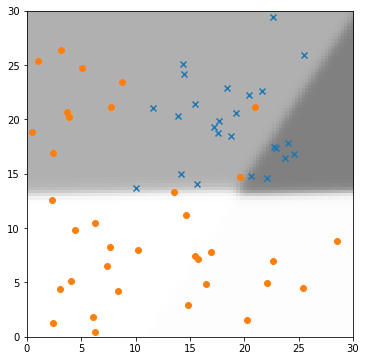

In [7]:
# --- 結果の可視化 ---
train_set0 = train_set[train_set['t'] == 0]
train_set1 = train_set[train_set['t'] == 1]

fig = plt.figure(figsize = (6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim(0, 30)
subplot.set_ylim(0, 30)
subplot.scatter(train_set1.x1, train_set1.x2, marker = 'x')
subplot.scatter(train_set0.x1, train_set0.x2, marker = 'o')

locations = []
for x2 in np.linspace(0, 30, 100):
    for x1 in np.linspace(0, 30, 100):
        locations.append((x1, x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100, 100))
subplot.imshow(p_vals, origin='lower', extent=(0, 30, 0, 30), cmap=plt.cm.gray_r, alpha=0.5)